In [ ]:
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

This code will apply various techniques in Machine Learning on the advection-diffusion equation, commonly found in many physics and engineering applications, particularly in fluid dynamics. Let $u(x, t)$ be a space-time dependent quantity, such as temperature or concentration in a fluid flow, its corresponding advection diffusion equation is given by

$$\frac{\partial u}{\partial t} = v \frac{\partial u}{\partial x} + D \frac{\partial^2 u}{\partial x^2},$$

where $D$ is a diffusion coefficient, $v$ is the advection coefficient describing the speed of the flow.

### Good-old numerical solver

In [ ]:
x_left = -2
x_right = 2
t_end = 2

D = 0.02
v = 0.1
dx = 0.01
dt = 0.001

cfl = D*dt/dx**2
print('CFL = %.4f'%(cfl))
x_steps = int((x_right - x_left)/dx)
t_steps = int(t_end/dt)

xx = np.linspace(x_left, x_right, x_steps)
tt = np.linspace(0, t_end, t_steps)
uu = np.zeros((t_steps, x_steps))

# ICs
def gaussian(x, mu, sig, shift):
    return shift + np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

ic_mean = 0
ic_std = 0.2
ic_shift = 0 
uu[0, :] = gaussian(xx, ic_mean, ic_std, ic_shift)

CFL = 0.2000


$$ u(x_i, t_{i+1}) = u(x_i, t_i) + D \left(\frac{\Delta t}{\Delta x}\right)^2  (u(x_{i-1}, t_i) - 2 u(x_i, t_i) + u(x_{i+1}, t_i) ) + v \frac{\Delta t}{2\Delta x} (u(x_{i+1}, t_i) - u(x_{i-1}, t_i))$$

In [ ]:
# Euler Stepper
def adv_diff_euler_step(ul, uc, ur, D, v, dx, dt):
    return uc + D * dt/dx**2 * (ul - 2 * uc + ur) + v * dt/(2*dx) * (ur - ul)

# Solve
inputs = []
outputs = []
for ti, t in enumerate(tt[:-1]):
    for xi, x in enumerate(xx[1:-1]):
        uu[ti+1, xi] = adv_diff_euler_step(uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1], D, v, dx, dt)

        # zero flux BC
        uu[ti+1, 0] = uu[ti+1, 1]
        uu[ti+1, -1] = uu[ti+1, -2]

        # Save data
        inputs.append([t, x])
        outputs.append(uu[ti+1, xi])


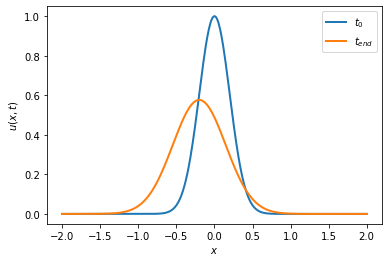

In [ ]:
fig = plt.figure()
plt.plot(xx, uu[0, :], lw=2)
plt.plot(xx, uu[-1, :], lw=2)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.legend(['$t_0$', '$t_{end}$'])


plt.show()

### Approximate the solution by a neural network?
A *naive* first step would be to approximate the function $u(x, t)$ by building a neural network with inputs $(x, t)$ and output $u$. Such a network can be useful for surrogate modeling.

In [ ]:
test_ratio = 0.25
dev_ratio = 0.2

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=False)

In [ ]:

# Build model
deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(10, input_dim=2, activation='elu'))
deep_approx.add(layers.Dense(10, activation='elu'))
deep_approx.add(layers.Dense(1, activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_approx.fit(X_train, y_train, 
            epochs=10, batch_size=32, 
            validation_data=(X_dev, y_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
14918/14918 [==============================] - 22s 1ms/step - loss: 0.0146 - val_loss: 4.2067e-04
Epoch 2/10
14918/14918 [==============================] - 21s 1ms/step - loss: 2.4455e-04 - val_loss: 1.5875e-04
Epoch 3/10
14918/14918 [==============================] - 21s 1ms/step - loss: 1.4117e-04 - val_loss: 1.3537e-04
Epoch 4/10
14918/14918 [==============================] - 21s 1ms/step - loss: 9.3146e-05 - val_loss: 1.6698e-04
Epoch 5/10
14918/14918 [==============================] - 21s 1ms/step - loss: 6.1776e-05 - val_loss: 1.5959e-04
Epoch 6/10
14918/14918 [==============================] - 21s 1ms/step - loss: 4.4186e-05 - val_loss: 1.6316e-04
Epoch 7/10
14918/14918 [==============================] - 21s 1ms/step - loss: 3.4193e-05 - val_loss: 1.7513e-04
Epoch 8/10
14918/14918 [==============================] - 21s 1ms/step - loss: 2.8389e-05 - val_loss: 1.0539e-04
Epoch 9/10
14918/14918 [==============================] - 21s 1ms/step - loss: 2.4172e-05 - val_loss

In [ ]:
deep_approx.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


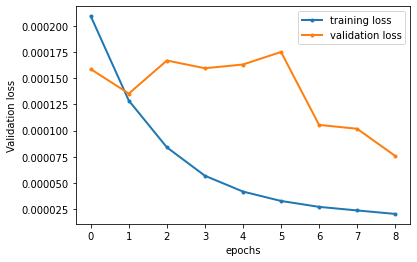

In [ ]:
# history.history contains loss information

idx0 = 1
plt.figure()
plt.plot(history.history['loss'][idx0:], '.-', lw=2)
plt.plot(history.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

#### Does it extrapolate in time?

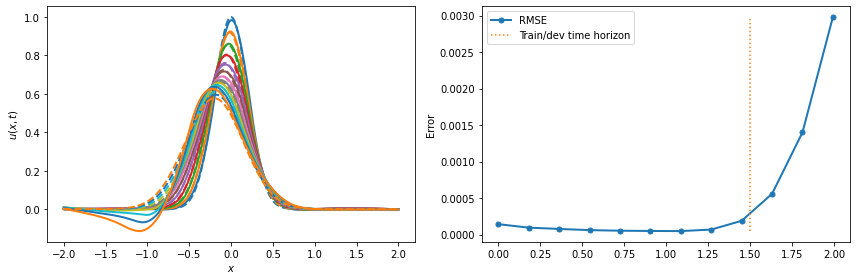

In [ ]:
import seaborn as sns
c = sns.color_palette()

nplots = 11
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    u_approx = deep_approx.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)])
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

### Approximate the integrator by a neural network (RNN)
We can basically fit the coefficient of the Euler stepping function we used above `adv_diff_euler_step(ul, uc, ur, D, v, dx, dt)`. If we ignore its dependence on input parameters, we're approximating the function $\phi$ in

$$u(t_i, x_i) = \phi(u(t_{i-1}, x_{i-1}), u(t_{i-1}, x_{i}), u(t_{i-1}, x_{i+1}))$$

In dynamical systems where the state $u$ only depends on time, $\phi$ is commonly referred as a **flow map**, and we look to approximate the function
$$ u(t_i) = \phi(u(t_{i-1})) $$

These paper use this approach:
- https://www.youtube.com/watch?v=Jfl3dIlSTrU
- 

In [ ]:
# Let's run the simulation and save the data at each step

inputs = []
outputs = []
for ti, t in enumerate(tt[:-1]):
    for xi, x in enumerate(xx[1:-1]):
        uu[ti+1, xi] = adv_diff_euler_step(uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1], D, v, dx, dt)
        uu[ti+1, 0] = uu[ti+1, 1]
        uu[ti+1, -1] = uu[ti+1, -2]

        # Collect data
        inputs.append([uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1]])
        outputs.append(uu[ti+1, xi])

inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
Xs_train, Xs_dev, ys_train, ys_dev = train_test_split(Xs_train, ys_train, test_size=dev_ratio, shuffle=True)

In [ ]:
## linear regression of stepper

# Build model
deep_stepper = keras.models.Sequential()
deep_stepper.add(layers.Dense(1, input_dim=3, activation='linear'))

# Compile model
deep_stepper.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_stepper.fit(Xs_train, ys_train, epochs=3, batch_size=32, 
            validation_data=(Xs_dev, ys_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/3
14918/14918 [==============================] - 19s 1ms/step - loss: 0.0434 - val_loss: 6.9518e-06
Epoch 2/3
14918/14918 [==============================] - 17s 1ms/step - loss: 1.9073e-06 - val_loss: 4.8422e-10
Epoch 3/3
14918/14918 [==============================] - 17s 1ms/step - loss: 8.4980e-09 - val_loss: 5.1057e-10


In [ ]:
## Integrate with the neural network
# WARNING (and lesson): this will take too long! (around 10 minutes)
# Can accelerate by vectorizing input_stencil
	
from tqdm import tqdm 

uu_deep = np.zeros(uu.shape)
uu_deep[0, :] = uu[0, :]

for ti in tqdm(range(len(tt[:-1]))):
    for xi, x in enumerate(xx[1:-1]):
        input_stencil = np.array([[uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1]]])
        uu_deep[ti+1, xi] = deep_stepper( input_stencil )[0][0].numpy()
    uu_deep[ti+1, 0] = uu_deep[ti+1, 1]
    uu_deep[ti+1, -1] = uu_deep[ti+1, -2]

100%|██████████| 1999/1999 [09:23<00:00,  3.55it/s]


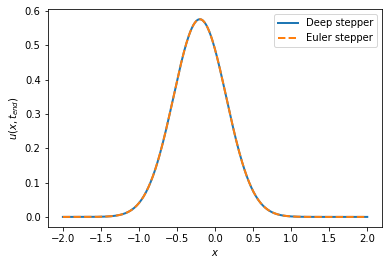

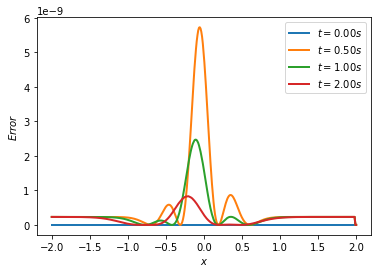

In [ ]:
fig = plt.figure()
plt.plot(xx, uu_deep[-1, :], lw=2)
plt.plot(xx, uu[-1, :], '--', lw=2)
plt.xlabel('$x$')
plt.ylabel('$u(x, t_{end})$')
plt.legend(['Deep stepper', 'Euler stepper'])

idx_list = [0, int(len(tt)/4), int(len(tt)/2), int(len(tt))-1]
leg = []
fig = plt.figure()
for idx in idx_list:
    plt.plot(xx, (uu_deep[idx, :] - uu[idx, :])**2, lw=2)
    leg.append('$t=%.2f s$'%(tt[idx]))
plt.xlabel('$x$')
plt.ylabel('$Error$')
plt.legend(leg)


In [ ]:
# If the time stepper is linear. Does it learn the right coefficients?

# Euler step: uc + D * dt/dx**2 * (ul - 2 * uc + ur) + v * dt/(2*dx) * (ur - ul)

weights = deep_stepper.get_weights()[0]
bias = deep_stepper.get_weights()[1]

print("actual coefficient of u_left is %.5f and the fit is %.5f"%(D*dt/dx**2 - v*dt/(2*dx), weights[0]))
print("actual coefficient of u_center is %.5f and the fit is %.5f"%(-2*D*dt/dx**2 + 1, weights[1]) )
print("actual coefficient of u_right is %.5f and the fit is %.5f"%(D*dt/dx**2 + v*dt/(2*dx), weights[2]))
print(bias)

## In general, you're not guaranteed to get the same solution.

actual coefficient of u_left is 0.19500 and the fit is 0.25546
actual coefficient of u_center is 0.60000 and the fit is 0.47929
actual coefficient of u_right is 0.20500 and the fit is 0.26528
[-1.5215408e-05]


In [ ]:
## Nonlinear regression of stepper

# Build model
deep_stepper2 = keras.models.Sequential()
deep_stepper2.add(layers.Dense(2, input_dim=3, activation='elu'))
deep_stepper2.add(layers.Dense(10, activation='elu'))
deep_stepper2.add(layers.Dense(1, activation='linear'))

# Compile model
deep_stepper2.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_stepper2.fit(Xs_train, ys_train, epochs=3, batch_size=32, 
            validation_data=(Xs_dev, ys_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

In [ ]:
## Integrate with the neural network
# WARNING (and lesson): this will take too long! (around 10 minutes)
# Can accelerate by vectorizing input_stencil

uu_deep2 = np.zeros(uu.shape)
uu_deep2[0, :] = uu[0, :]

for ti, t in enumerate(tt[:-1]):
    # print(ti/len(tt))
    for xi, x in enumerate(xx[1:-1]):
        input_stencil = np.array([[uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1]]])
        uu_deep2[ti+1, xi] = deep_stepper2( input_stencil )[0][0].numpy()
    uu_deep2[ti+1, 0] = uu_deep2[ti+1, 1]
    uu_deep2[ti+1, -1] = uu_deep2[ti+1, -2]

In [ ]:
fig = plt.figure()
plt.plot(xx, uu_deep[-1, :], lw=2)
plt.plot(xx, uu_deep2[-1, :], lw=2)
plt.plot(xx, uu[-1, :], lw=2, '--')
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.legend(['Deep stepper', 'Euler stepper'])

idx_list = [0, int(len(tt)/4), int(len(tt)/2), int(len(tt))-1]
leg = []
fig = plt.figure()
for idx in idx_list:
    plt.plot(xx, (uu_deep[idx, :] - uu[idx, :])**2, lw=2)
    leg.append(str(tt[idx]))
plt.xlabel('$x$')
plt.ylabel('$Error$')
plt.legend(leg)


#### Generalize over $D$, $v$, $dx$, $dt$?